In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/home/ubuntu/sustaingym


In [8]:
import sys
sys.path.append('../')

from typing import List

import numpy as np
import os
import pandas as pd
import gym
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import matplotlib.ticker as plticker

fmt = mdates.DateFormatter('%H:%M:%S')

data_path = os.path.join(os.getcwd(), 'sustaingym/data')

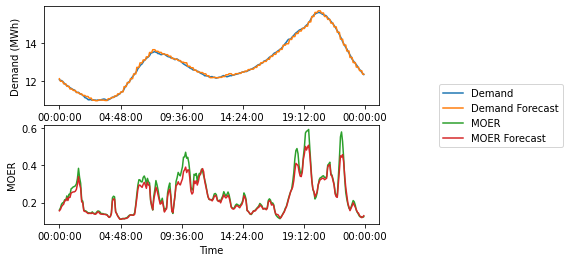

In [12]:
"""
Plots for forecasts versus actual load and moer values.
"""

color_cycle = plt.rcParams['axes.prop_cycle']()

df_load = pd.read_csv(f'{data_path}/demand_data/CAISO-demand-2019-05.csv.gz', compression='gzip', index_col=0)
df_load_forecast = pd.read_csv(f'{data_path}/demand_forecast_data/CAISO-demand-forecast-2019-05.csv.gz', compression='gzip', index_col=0)
df_moer = pd.read_csv(f'{data_path}/moer/SGIP_CAISO_SCE_2019-05.csv.gz', compression='gzip', index_col=0)

time_arr = df_load.columns[:-1]
time_arr = [t + ':00.0' for t in time_arr]
timeArray = [datetime.datetime.strptime(i, '%H:%M:%S.%f') for i in time_arr]

load = np.array(df_load.iloc[0,:-1] / 1800.0)
load_forecast = np.array(df_load_forecast.iloc[0,:-1] / 1800.0)
moer = np.array(df_moer.iloc[288:576, 1])
moer_forecast = np.array(df_moer.iloc[288:576, 2])

fig, (ax1, ax2)  = plt.subplots(2)

ax1.plot(timeArray, load, label='Demand', **next(color_cycle))
ax1.plot(timeArray, load_forecast, label='Demand Forecast', **next(color_cycle))
ax2.plot(timeArray, moer, label='MOER', **next(color_cycle))
ax2.plot(timeArray, moer_forecast, label='MOER Forecast', **next(color_cycle))

ax1.set_ylabel('Demand (MWh)')
ax2.set_ylabel('MOER')

ax2.set_xlabel('Time')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

ax1.xaxis.set_major_formatter(fmt)
ax2.xaxis.set_major_formatter(fmt)
loc = plticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
ax1.xaxis.set_major_locator(loc)
ax2.xaxis.set_major_locator(loc)

fig.legend(lines, labels, bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

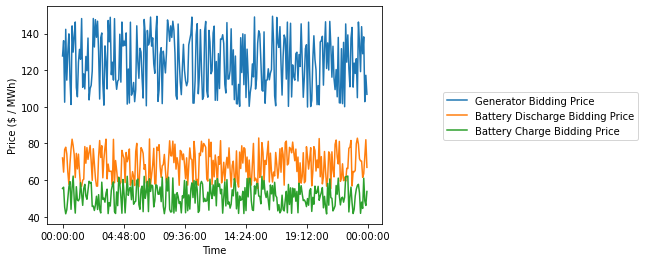

In [13]:
"""
Plots for simulated bid prices.
"""

color_cycle = plt.rcParams['axes.prop_cycle']()

df_load = pd.read_csv(f'{data_path}/demand_data/CAISO-demand-2019-05.csv.gz', compression='gzip', index_col=0)

time_arr = df_load.columns[:-1]
time_arr = [t + ':00.0' for t in time_arr]
timeArray = [datetime.datetime.strptime(i, '%H:%M:%S.%f') for i in time_arr]

init_gen_cost = np.random.uniform(50, 150)
gen_costs = np.random.uniform(0.8*init_gen_cost, 1.2*init_gen_cost, len(timeArray))

init_discharge_cost = np.random.uniform(50, 100)
init_charge_cost = 0.75*init_discharge_cost
charge_costs = np.random.uniform(0.8*init_charge_cost, 1.2*init_charge_cost, len(timeArray))
discharge_costs = np.random.uniform(0.8*init_discharge_cost, 1.2*init_discharge_cost, len(timeArray))

fig, ax  = plt.subplots()

ax.plot(timeArray, gen_costs, label='Generator Bidding Price', **next(color_cycle))
ax.plot(timeArray, discharge_costs, label='Battery Discharge Bidding Price', **next(color_cycle))
ax.plot(timeArray, charge_costs, label='Battery Charge Bidding Price', **next(color_cycle))

ax.set_ylabel('Price ($ / MWh)')

ax.set_xlabel('Time')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

ax.xaxis.set_major_formatter(fmt)
loc = plticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)

fig.legend(lines, labels, bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

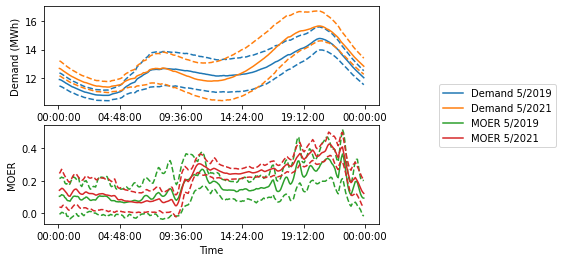

In [15]:
"""
Generating distribution shift plots.
"""

cmap = plt.get_cmap("tab10")

df_load_19_5 = pd.read_csv(f'{data_path}/demand_data/CAISO-demand-2019-05.csv.gz', compression='gzip', index_col=0)
# only month five is not in gzip format
df_moer_19_5 = pd.read_csv(f'{data_path}/moer/SGIP_CAISO_SCE_2019-05.csv.gz', compression='gzip', index_col=0)

df_load_21_5 = pd.read_csv(f'{data_path}/demand_data/CAISO-demand-2021-05.csv.gz', compression='gzip', index_col=0)
# only month five is not in gzip format
df_moer_21_5 = pd.read_csv(f'{data_path}/moer/SGIP_CAISO_SCE_2021-05.csv.gz', compression='gzip', index_col=0)

time_arr = df_load_19_5.columns[1:-1]
time_arr = [t + ':00.0' for t in time_arr]
timeArray = [datetime.datetime.strptime(i, '%H:%M:%S.%f') for i in time_arr]

avg_load_19_5 = np.zeros((len(timeArray),))
std_load_19_5 = np.zeros((len(timeArray),))

avg_load_21_5 = np.zeros((len(timeArray),))
std_load_21_5 = np.zeros((len(timeArray),))

avg_moer_19_5 = np.zeros((len(timeArray),))
std_moer_19_5 = np.zeros((len(timeArray),))

avg_moer_21_5 = np.zeros((len(timeArray),))
std_moer_21_5 = np.zeros((len(timeArray),))

for i in range(len(timeArray)):
    avg_load_19_5[i] = np.mean(df_load_19_5.iloc[1:, i+1] / 1800.0)
    std_load_19_5[i] = np.std(df_load_19_5.iloc[1:, i+1] / 1800.0)
    avg_load_21_5[i] = np.mean(df_load_21_5.iloc[1:, i+1] / 1800.0)
    std_load_21_5[i] = np.std(df_load_21_5.iloc[1:, i+1] / 1800.0)

    avg_moer_19_5[i] = np.mean(df_moer_19_5.iloc[288+i::288, 1])
    std_moer_19_5[i] = np.std(df_moer_19_5.iloc[288+i::288, 1])
    avg_moer_21_5[i] = np.mean(df_moer_21_5.iloc[288+i::288, 1])
    std_moer_21_5[i] = np.std(df_moer_21_5.iloc[288+i::288, 1])

fig, (ax1, ax2)  = plt.subplots(2)

ax1.plot(timeArray, avg_load_19_5, label='Demand 5/2019', color=cmap(0))
ax1.plot(timeArray, avg_load_19_5 + std_load_19_5, color=cmap(0), linestyle='dashed')
ax1.plot(timeArray, avg_load_19_5 - std_load_19_5, color=cmap(0), linestyle='dashed')

ax1.plot(timeArray, avg_load_21_5, label='Demand 5/2021', color=cmap(1))
ax1.plot(timeArray, avg_load_21_5 + std_load_21_5, color=cmap(1),linestyle='dashed')
ax1.plot(timeArray, avg_load_21_5 - std_load_21_5, color=cmap(1), linestyle='dashed')

ax2.plot(timeArray, avg_moer_19_5, label='MOER 5/2019', color=cmap(2))
ax2.plot(timeArray, avg_moer_19_5 + std_moer_19_5, color=cmap(2), linestyle='dashed')
ax2.plot(timeArray, avg_moer_19_5 - std_moer_19_5, color=cmap(2), linestyle='dashed')

ax2.plot(timeArray, avg_moer_21_5, label='MOER 5/2021', color=cmap(3))
ax2.plot(timeArray, avg_moer_21_5 + std_moer_21_5, color=cmap(3), linestyle='dashed')
ax2.plot(timeArray, avg_moer_21_5 - std_moer_21_5, color=cmap(3), linestyle='dashed')

ax1.set_ylabel('Demand (MWh)')
ax2.set_ylabel('MOER')

ax2.set_xlabel('Time')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

ax1.xaxis.set_major_formatter(fmt)
ax2.xaxis.set_major_formatter(fmt)
loc = plticker.MultipleLocator(base=0.2) # this locator puts ticks at regular intervals
ax1.xaxis.set_major_locator(loc)
ax2.xaxis.set_major_locator(loc)

fig.legend(lines, labels, bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()

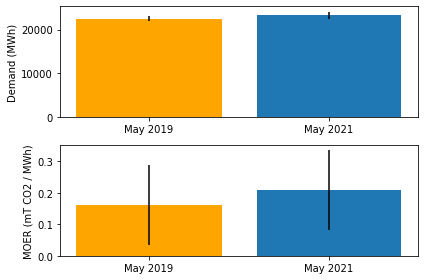

In [20]:
cmap = plt.get_cmap("tab10")

df_load_19_5 = pd.read_csv(f'{data_path}/demand_data/CAISO-demand-2019-05.csv.gz', compression='gzip', index_col=0)
# only month five is not in gzip format
df_moer_19_5 = pd.read_csv(f'{data_path}/moer/SGIP_CAISO_SCE_2019-05.csv.gz', compression='gzip', index_col=0)

df_load_21_5 = pd.read_csv(f'{data_path}/demand_data/CAISO-demand-2021-05.csv.gz', compression='gzip', index_col=0)
# only month five is not in gzip format
df_moer_21_5 = pd.read_csv(f'{data_path}/moer/SGIP_CAISO_SCE_2021-05.csv.gz', compression='gzip', index_col=0)

mean_moer_19_5 = np.mean(df_moer_19_5.iloc[288:, 1])
mean_moer_21_5 = np.mean(df_moer_21_5.iloc[288:, 1])
mean_demand_19_5 = np.mean(np.mean(df_load_19_5.iloc[1:, 1:]))
mean_demand_21_5 = np.mean(np.mean(df_load_21_5.iloc[1:, 1:]))

std_moer_19_5 = np.std(df_moer_19_5.iloc[288:, 1])
std_moer_21_5 = np.std(df_moer_21_5.iloc[288:, 1])
std_demand_19_5 = np.std(np.std(df_load_19_5.iloc[1:, 1:]))
std_demand_21_5 = np.std(np.std(df_load_21_5.iloc[1:, 1:]))

fig, (ax1, ax2)  = plt.subplots(2)

months = ['May 2019', 'May 2021']

ax1.bar([0, 1], [mean_demand_19_5, mean_demand_21_5], yerr=[std_demand_19_5, std_demand_21_5], align='center', ecolor='black')
ax2.bar([0, 1], [mean_moer_19_5, mean_moer_21_5], yerr=[std_moer_19_5, std_moer_21_5], align='center', ecolor='black')
ax1.set_ylabel('Demand (MWh)')
ax2.set_ylabel('MOER (mT CO2 / MWh)')
ax1.set_xticks([0,1])
ax1.set_xticklabels(months)
ax2.set_xticks([0,1])
ax2.set_xticklabels(months)
ax1.get_children()[0].set_color('orange') 
ax2.get_children()[0].set_color('orange') 

plt.tight_layout()
plt.show()